<a href="https://colab.research.google.com/github/Evanlerberghe-NU/MSDS451_Final/blob/main/MSDS451_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install asyncpraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 8.2 MB/s eta 0:00:00


In [ ]:
import time
import asyncio
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from numpy.random import multivariate_normal
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV

import asyncpraw
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

import requests
from bs4 import BeautifulSoup

def get_top_15_tickers():
    url = "https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/"
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, "html.parser")

    tickers = []
    for div in soup.find_all("div", class_="company-code"):
        ticker = div.text.strip()
        # Skip any tickers with a dash - Berkshire B casues major problems with Yfinance for some reason
        if "-" in ticker:
            continue
        tickers.append(ticker)
        if len(tickers) >= 10:
            break
    return tickers

tickers = get_top_15_tickers()
print("Top 15 NYSE tickers by market cap", tickers)

#tTesting tickers = ["NVDA", "MSFT", "AAPL", "GOOGL", "AMZN", "AVGO", "TSLA", "JPM", "TSM"]
benchmark = "^GSPC"
start_date = "2022-01-01"
end_date = "2024-12-31"

management_fee = 0.02
performance_fee_rate = 0.2
risk_free_rate = 0.01

n_simulations = 10000
n_days = 1







Top 15 NYSE tickers by market cap ['NVDA', 'MSFT', 'AAPL', 'GOOG', 'AMZN', 'META', 'AVGO', 'TSLA', 'JPM', 'WMT']


In [ ]:
# Reddit API credentials - Plz dont steal
reddit = asyncpraw.Reddit(
    client_id="YtI5zCSgp0dmu84mSVTM7g",
    client_secret="Vx3UbtW6pSlwQ9kqtSfQMniMzhinMg",
    user_agent="algo-trading-bot by u/National-Tune3181"
)

nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()

#Reddit sentiment funcationality, based on Sam120204's project
async def scrape_reddit_posts(ticker: str, subreddit: str = "stocks", limit: int = 50):
    try:
        subreddit_obj = await reddit.subreddit(subreddit)
        posts = subreddit_obj.search(ticker, sort="new", limit=limit)
        texts = []
        async for post in posts:
            text = post.title + " " + (post.selftext if post.selftext else "")
            texts.append(text)
        return texts
    except Exception as e:
        print(f"Reddit scrape failed for {ticker}: {e}")
        return []

def sentiment_score(texts):
    if not texts:
        return 0.0
    scores = [sia.polarity_scores(t)["compound"] for t in texts]
    return float(np.mean(scores)) if scores else 0.0

#Collect data from WallStreetBets, since they went big in 2022
async def collect_sentiment():
    results = {}
    for t in tickers:
        posts = await scrape_reddit_posts(t, subreddit="wallstreetbets", limit=250)
        s = sentiment_score(posts)
        results[t] = s
    return results

def run_async(coro):
    try:
        return asyncio.run(coro)
    except RuntimeError:
        import nest_asyncio
        nest_asyncio.apply()
        loop = asyncio.get_event_loop()
        return loop.run_until_complete(coro)

sentiment_results = run_async(collect_sentiment())
print("Sentiment Index:", sentiment_results)




Sentiment Index: {'NVDA': 0.2574879032258065, 'MSFT': 0.33827205240174674, 'AAPL': 0.21569214876033058, 'GOOG': 0.3337283898305084, 'AMZN': 0.27612904564315355, 'META': 0.39015454545454553, 'AVGO': 0.32349755102040817, 'TSLA': 0.1665604081632653, 'JPM': 0.28444851063829785, 'WMT': -0.014193902439024395}


In [ ]:
#Data from Yahoo Finance
data = yf.download(tickers + [benchmark],
                   start=start_date, end=end_date,
                   interval="1d", group_by='ticker', auto_adjust=True)

def compute_log_returns(prices: pd.Series) -> pd.Series:
    return np.log(prices / prices.shift(1)).dropna()

returns = {t: compute_log_returns(data[t]["Close"]) for t in tickers}
benchmark_returns = compute_log_returns(data[benchmark]["Close"])
returns_df = pd.DataFrame(returns)

for t in tickers:
    returns_df[f"{t}_sentiment"] = sentiment_results[t]

#Monte Carlo Simulation - based on those by Hansen-Han and on HW Assignment 2
mean_returns = returns_df[tickers].mean().values
cov_matrix = returns_df[tickers].cov().values
simulated_returns = multivariate_normal(mean_returns, cov_matrix, (n_simulations, n_days))

def random_weights(n_assets: int) -> np.ndarray:
    w = np.random.rand(n_assets)
    return w / np.sum(w)

weights_list = np.array([random_weights(len(tickers)) for _ in range(n_simulations)])
portfolio_returns = np.einsum('ijk,ik->ij', simulated_returns, weights_list)
portfolio_cum_returns = np.exp(portfolio_returns.cumsum(axis=1))

hist_df = returns_df[tickers].copy()
hist_mean = hist_df.mean()
hist_cov = hist_df.cov()

sharpe_ratios, weights_store = [], []
for _ in range(10000):
    w = random_weights(len(tickers))
    port_ret = float(np.dot(hist_mean, w))
    port_vol = float(np.sqrt(np.dot(w.T, np.dot(hist_cov, w))))
    sharpe = (port_ret - risk_free_rate) / port_vol if port_vol != 0 else -np.inf
    sharpe_ratios.append(sharpe)
    weights_store.append(w)

best_weights = weights_store[int(np.argmax(sharpe_ratios))]
print("Run 42 selected for backtesting") #Shoutout Hitchiker's guide to the galaxy

hist_portfolio_returns = hist_df.dot(best_weights)
hist_portfolio_cum = np.exp(hist_portfolio_returns.cumsum())
all_SF_returns = []



[*********************100%***********************]  11 of 11 completed


Run 42 selected for backtesting


In [ ]:

for ticker in tickers:
    print(f"\n=== Training model for {ticker} ===")
    X_full = returns_df.copy()
    y_next = X_full.shift(-1)[ticker]
    y_next_class = (y_next > 0).astype(int)

    aligned_ml = pd.concat([X_full, y_next_class.rename("target")], axis=1).dropna()
    X_ml = aligned_ml.drop(columns=["target"])
    y_ml = aligned_ml["target"]

    X_train, X_test, y_train, y_test = train_test_split(
        X_ml, y_ml, shuffle=False, test_size=0.2
    )

    # Hyperparameter grid to startt
    param_grid = {
        "n_estimators": [100],
        "learning_rate": [0.05],
        "max_depth": [5],
        "subsample": [0.8],
        "colsample_bytree": [0.8]
    }

    xgb = XGBClassifier(
        random_state=42, #Shoutout Hitchiker's guide to the galaxy, again
        use_label_encoder=False,
        eval_metric="logloss",
        n_jobs=-1
    )

    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        cv=3,
        scoring="accuracy",
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{ticker} Test Accuracy: {acc:.4f}")

    # Include Shortselling - found in video
    train_size = int(0.8 * len(X_ml))
    X_backtest = X_ml.iloc[train_size:]
    dates_backtest = X_backtest.index
    preds = best_model.predict(X_backtest)
    signals = pd.Series(np.where(preds == 1, 1, -1), index=dates_backtest)

    asset_returns = returns[ticker].loc[dates_backtest]
    strat_returns = asset_returns * signals.shift(1).fillna(0)
    all_SF_returns.append(strat_returns)




=== Training model for NVDA ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:33:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


NVDA Test Accuracy: 0.4702

=== Training model for MSFT ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:33:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


MSFT Test Accuracy: 0.5099

=== Training model for AAPL ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:33:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AAPL Test Accuracy: 0.5364

=== Training model for GOOG ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:33:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GOOG Test Accuracy: 0.5497

=== Training model for AMZN ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:33:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AMZN Test Accuracy: 0.5298

=== Training model for META ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:33:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


META Test Accuracy: 0.5166

=== Training model for AVGO ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:33:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AVGO Test Accuracy: 0.5298

=== Training model for TSLA ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:33:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


TSLA Test Accuracy: 0.5364

=== Training model for JPM ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:33:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


JPM Test Accuracy: 0.5828

=== Training model for WMT ===
WMT Test Accuracy: 0.5033


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:33:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


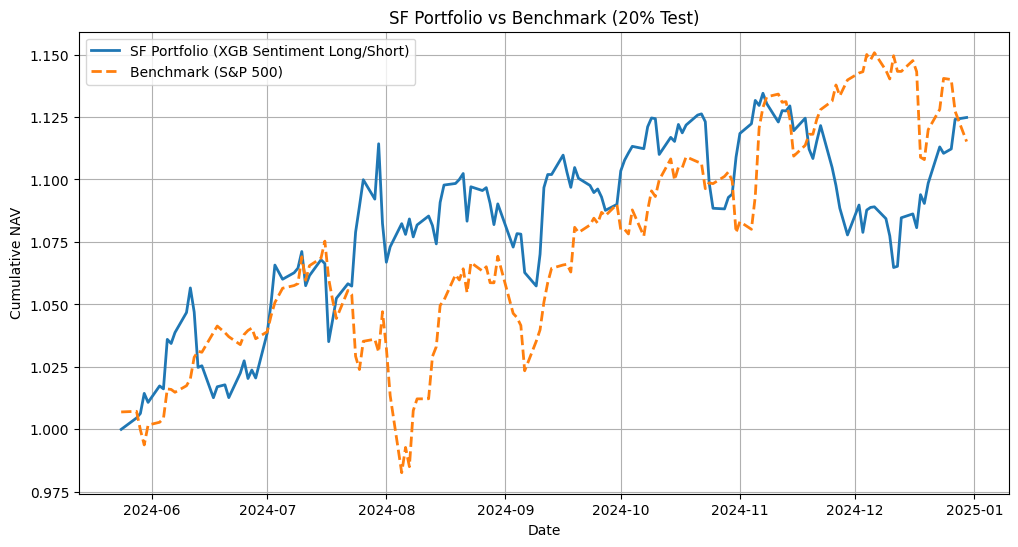


=== Backtest Results (20% Test) ===
SF Total Return: 12.48%
Benchmark Total Return: 11.52%
SF Sharpe Ratio: 1.3868
Benchmark Sharpe Ratio: 0.3417
Alpha: 0.0008
Beta: 0.0390
Total management fees earned: $823.97
Total performance fees earned: $0.12
Total fees earned (management + performance): $824.09


In [ ]:
portfolio_SF_returns = pd.concat(all_SF_returns, axis=1).mean(axis=1)

SF_nav = (1 + portfolio_SF_returns).cumprod()
benchmark_nav = (1 + benchmark_returns.loc[SF_nav.index]).cumprod()

plt.figure(figsize=(12,6))
plt.plot(SF_nav, label="SF Portfolio (XGB Sentiment Long/Short)", linewidth=2)
plt.plot(benchmark_nav, label="Benchmark (S&P 500)", linewidth=2, linestyle="--")
plt.title("SF Portfolio vs Benchmark (20% Test)")
plt.xlabel("Date")
plt.ylabel("Cumulative NAV")
plt.legend()
plt.grid()
plt.show()

aligned = pd.concat([benchmark_returns, portfolio_SF_returns], axis=1).dropna()
aligned.columns = ["Benchmark", "SF"]

#Calculate Alpha, Beta, Sharpe, Retun
x = aligned["Benchmark"].values.reshape(-1, 1)
y = aligned["SF"].values
lin_model = LinearRegression().fit(x, y)

beta = float(lin_model.coef_[0])
alpha = float(lin_model.intercept_)
sharpe_ratio = (portfolio_SF_returns.mean() - risk_free_rate/252) / portfolio_SF_returns.std() * np.sqrt(252)

SF_total_return = SF_nav.iloc[-1] - 1
benchmark_total_return = benchmark_nav.iloc[-1] - 1

SF_sharpe = (portfolio_SF_returns.mean() - risk_free_rate/252) / portfolio_SF_returns.std() * np.sqrt(252)
benchmark_sharpe = (benchmark_returns.mean() - risk_free_rate/252) / benchmark_returns.std() * np.sqrt(252)

print("\n=== Backtest Results (20% Test) ===")
print(f"SF Total Return: {SF_total_return:.2%}")
print(f"Benchmark Total Return: {benchmark_total_return:.2%}")
print(f"SF Sharpe Ratio: {SF_sharpe:.4f}")
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe:.4f}")
print(f"Alpha: {alpha:.4f}")
print(f"Beta: {beta:.4f}")

daily_mgmt_fee_rate = management_fee * 252  # 252 trading days per year
fees_mgmt = SF_nav * daily_mgmt_fee_rate
total_mgmt_fees = fees_mgmt.sum()

daily_profit = SF_nav.diff().fillna(0)
perf_fee_daily = daily_profit.clip(lower=0) * performance_fee_rate
total_perf_fees = perf_fee_daily.sum()

total_fees = total_mgmt_fees + total_perf_fees

print(f"Total management fees earned: ${total_mgmt_fees:,.2f}")
print(f"Total performance fees earned: ${total_perf_fees:,.2f}")
print(f"Total fees earned (management + performance): ${total_fees:,.2f}")

